In [ ]:
%pip install datasets transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 599.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 2.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.


In [ ]:
import torch
import transformers
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import pandas as pd
import numpy as np
import random
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#!g1.1
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-large')
model = BertForSequenceClassification.from_pretrained('sberbank-ai/ruBert-large', num_labels=6).to("cuda")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#!g1.1
texts = pd.read_csv("/home/jupyter/work/resources/Untitled Folder/+С2_RuFoLa_corpus - +С2_RuFoLa_corpus.csv")
texts

,id,level,source,text,source.1,keys
0,1,1,jilibili_1,Это мой друг. Это моя подруга. Это мой дом. Эт...,NaN,NaN
1,2,1,jilibili_1,Это я. Меня зовут Анна. Я студентка.Это мой от...,NaN,NaN
2,3,1,jilibili_1,Это Иван Петрович Сидоров. А это его ученики. ...,NaN,NaN
3,4,1,jilibili_1,Мы изучаем русский ЯЗЫК.Это наша аудитория. Се...,NaN,NaN
4,5,1,jilibili_1,Наш город.Петербург.Он не очень старый. Здесь ...,NaN,NaN
...,...,...,...,...,...,...
2082,2098,6,youlang,"Конечно же, не стоит забывать об элементарных ...",NaN,NaN
2083,2099,6,youlang,Светлана Комарова: кандидат психологических на...,NaN,NaN
2084,2100,6,youlang,"Наталья Искра: кандидат психологических наук, ...",NaN,NaN
2085,2101,6,youlang,На принятие решения о создании семьи в первую ...,NaN,NaN


In [ ]:
#!g1.1
x_train, x_test, y_train, y_test = train_test_split(texts['text'], texts['level'], test_size=0.2, random_state=42)

In [ ]:
#!g1.1
x_train = x_train.reset_index()                 # чтобы индексы шли подряд
x_test = x_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [ ]:
#!g1.1
le = LabelEncoder()
y_train = le.fit_transform(y_train['level'])              # меняем метки классов с 1-6 на 0-5
y_test = le.fit_transform(y_test['level'])

In [ ]:
#!g1.1
input_texts = x_train['text']
labels = y_train

In [ ]:
# #!g1.1                                                       низкое качество
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=0)
# x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

In [ ]:
#!g1.1
# Tokenize input texts
input_ids = []
attention_masks = []
for text in input_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 512,
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

/home/jupyter/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#!g1.1
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Делаем oversampling с помощью SMOTE:

In [ ]:
#!g1.1
concat = torch.cat((input_ids, attention_masks), dim=1)    # конкатенируем для SMOTE

In [ ]:
#!g1.1
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(concat, labels)


In [ ]:
#!g1.1
input_ids =  torch.tensor(x_train_resampled[:, :input_ids.shape[1]])     # делим уже сбалансированные данные
attention_masks =  torch.tensor(x_train_resampled[:, input_ids.shape[1]:])

In [ ]:
#!g1.1
# Create a DataLoader for training
dataset = TensorDataset(input_ids, attention_masks, torch.tensor(y_train_resampled))
batch_size = 8
dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

In [ ]:
#!g1.1
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 20
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/home/jupyter/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#!g1.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024

In [ ]:
#!g1.2
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(dataloader)
    print(f"Epoch: {epoch+1}")
    print(f"Average training loss: {avg_train_loss}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:132: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "


Epoch: 1
Average training loss: 1.4374832538274094
Epoch: 2
Average training loss: 1.1663234043428754
Epoch: 3
Average training loss: 0.8950797491907049
Epoch: 4
Average training loss: 0.6540690240554277
Epoch: 5
Average training loss: 0.46006683960428896
Epoch: 6
Average training loss: 0.34083756508791346
Epoch: 7
Average training loss: 0.2219914336412622
Epoch: 8
Average training loss: 0.1523939349460429
Epoch: 9
Average training loss: 0.09036149545392572
Epoch: 10
Average training loss: 0.03669573655703911
Epoch: 11
Average training loss: 0.02285181546630805
Epoch: 12
Average training loss: 0.026863096983880497
Epoch: 13
Average training loss: 0.011028638986057073
Epoch: 14
Average training loss: 0.009878419357544427
Epoch: 15
Average training loss: 0.010611707970821385
Epoch: 16
Average training loss: 0.007140428251320834
Epoch: 17
Average training loss: 0.004410970524053675
Epoch: 18
Average training loss: 0.0039667090008943945
Epoch: 19
Average training loss: 0.004091876707647535

In [ ]:
#!g1.1
# Save the trained model
output_dir = './RKI_sber_bert_large/'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./RKI_sber_bert_large/tokenizer_config.json',
 './RKI_sber_bert_large/special_tokens_map.json',
 './RKI_sber_bert_large/vocab.txt',
 './RKI_sber_bert_large/added_tokens.json')

Текструем модель:

In [ ]:
#!g1.1
test_input_texts = x_test['text']
test_input_ids = []
test_attention_masks = []

In [ ]:
#!g1.1
for text in test_input_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 512,
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#!g1.1
# Create a DataLoader for testing
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


In [ ]:
#!g1.1
model.eval()
predictions = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, test_attention_masks = batch
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=test_attention_masks)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)
    predictions.extend(predicted_labels.cpu().numpy())

print("Predictions:", predictions)

Predictions: [0, 2, 3, 3, 2, 3, 2, 3, 1, 0, 1, 1, 2, 1, 2, 4, 4, 2, 4, 4, 2, 4, 2, 4, 0, 4, 3, 0, 2, 4, 1, 2, 2, 2, 4, 3, 2, 1, 3, 3, 2, 4, 0, 2, 2, 3, 2, 2, 1, 5, 4, 3, 0, 5, 3, 4, 3, 1, 4, 3, 4, 2, 2, 2, 3, 2, 4, 3, 2, 1, 3, 3, 1, 0, 0, 2, 1, 1, 0, 0, 4, 3, 2, 1, 2, 2, 2, 4, 2, 1, 1, 1, 0, 2, 0, 2, 1, 1, 4, 5, 2, 4, 2, 4, 0, 1, 1, 2, 1, 3, 3, 1, 1, 0, 2, 2, 0, 1, 3, 2, 0, 3, 1, 2, 4, 2, 4, 2, 4, 1, 1, 2, 3, 1, 3, 4, 4, 1, 0, 0, 2, 2, 0, 3, 1, 4, 0, 1, 2, 4, 3, 2, 5, 4, 2, 2, 3, 2, 2, 0, 2, 1, 1, 4, 1, 2, 4, 3, 3, 2, 0, 1, 1, 3, 2, 4, 2, 1, 4, 0, 3, 3, 1, 2, 1, 4, 1, 2, 4, 0, 2, 2, 3, 3, 2, 2, 1, 0, 4, 1, 1, 1, 4, 0, 4, 3, 0, 4, 2, 4, 2, 2, 2, 2, 2, 1, 5, 5, 4, 2, 2, 1, 3, 4, 0, 2, 4, 2, 3, 0, 1, 3, 1, 0, 3, 1, 4, 1, 1, 2, 0, 1, 3, 2, 2, 3, 4, 3, 2, 1, 2, 2, 2, 3, 0, 3, 2, 3, 1, 0, 2, 2, 1, 2, 1, 4, 1, 0, 0, 2, 4, 2, 2, 2, 2, 1, 4, 2, 0, 3, 4, 3, 1, 3, 0, 3, 2, 3, 2, 1, 0, 4, 0, 1, 1, 0, 1, 2, 2, 4, 4, 3, 1, 0, 4, 2, 1, 2, 3, 2, 1, 2, 3, 0, 1, 2, 3, 0, 4, 2, 0, 4, 4, 0, 2, 1, 4, 1, 3,

In [ ]:
#!g1.1
print(classification_report(y_test, predictions))
print(f1_score(y_test, predictions, average=None))

              precision    recall  f1-score   support

           0       0.95      0.79      0.87        77
           1       0.55      0.81      0.66        58
           2       0.77      0.77      0.77       121
           3       0.63      0.65      0.64        69
           4       0.85      0.71      0.77        79
           5       0.82      0.64      0.72        14

    accuracy                           0.74       418
   macro avg       0.76      0.73      0.74       418
weighted avg       0.77      0.74      0.75       418

[0.86524823 0.65734266 0.76859504 0.64285714 0.77241379 0.72      ]


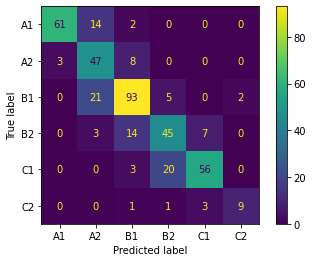

In [ ]:
#!g1.1
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=[0, 1, 2, 3, 4, 5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
disp.plot()
plt.show()

Качество метрики, допускающей ошибку на уровень вниз:

In [ ]:
def acceptable_accuracy(true_labels, predicted_labels):
    tp = 0
    wrong = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == true_labels[i] or predicted_labels[i] == true_labels[i]-1:
            tp += 1
        else:
            wrong += 1
    return tp / (tp + wrong)

In [ ]:
acceptable_accuracy(y_test, predictions)

0.8899521531100478